In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [ ]:
###create dataset
train_data=datasets.FashionMNIST(root="data",download=True,train=True,transform=ToTensor(), target_transform=None)
test_data=datasets.FashionMNIST(root="data",download=True,train=False,transform=ToTensor())

train_data, test_data

100%|██████████| 26421880/26421880 [00:03<00:00, 8539267.84it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 145682.51it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2662964.38it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22306071.27it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
test_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
class_names=train_data.classes

In [ ]:
image, label=train_data[6]
image.shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

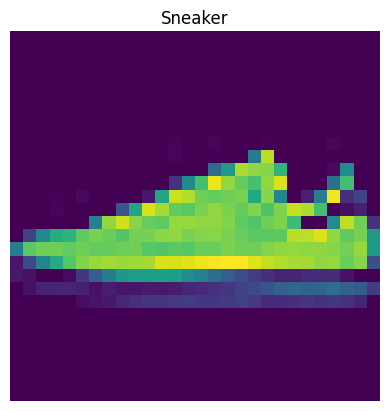

In [ ]:
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)

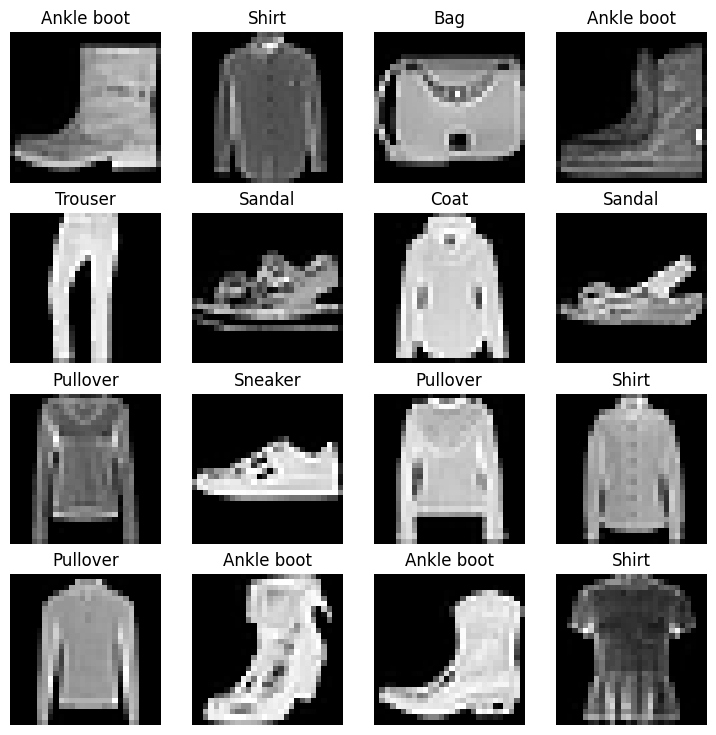

In [ ]:
torch.manual_seed(42)
fig=plt.figure(figsize=(9,9))
rows , cols= 4, 4
for i in range(1,rows*cols+1):
  random_idx=torch.randint(0, len(train_data), size=[1]).item()
  img, label=train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)


In [ ]:
batch_size=32

train_dataloader=DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True)
test_dataloader=DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False
)

train_dataloader,test_dataloader           

(<torch.utils.data.dataloader.DataLoader at 0x7f5be67b4e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5be67b4b20>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
train_features, train_labels= next(iter(train_dataloader))
train_features.shape, train_labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

torch.Size([1, 28, 28])


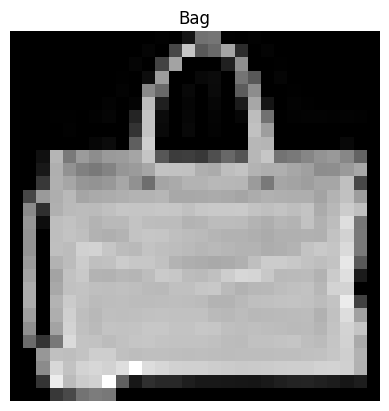

In [ ]:

random_idx= torch.randint(0, len(train_features), size=[1]).item()
image, label=train_features[random_idx], train_labels[random_idx]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(image.shape)

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
###replicating TinyVGG structure
from torch.nn.modules.pooling import MaxPool2d
class FashionModel_1(nn.Module):
  def __init__(self,input_shape:int,output_shape:int, hidden_units:int):
    super().__init__()
    self.Conv_block1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        
    )
    self.Conv_block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.Classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*7*7,
            out_features=output_shape,
        ))

  def forward(self,x):
    x=self.Conv_block1(x)
    #print(x.shape)
    x=self.Conv_block2(x)
    #print(x.shape)
    x=self.Classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
# we have only one color channel (gray) that's why we give 1 to input_shape
model1=FashionModel_1(input_shape=1,
                      hidden_units=10,
                      output_shape=len(class_names)).to(device)

model1

FashionModel_1(
  (Conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

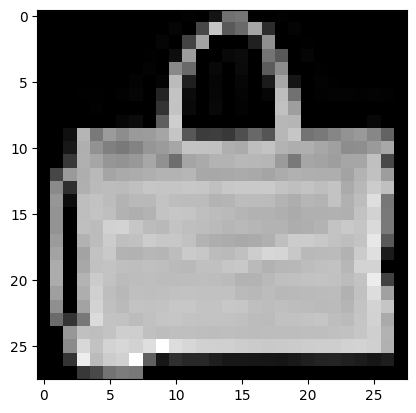

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

In [ ]:
model1(image.unsqueeze(0).to(device))

tensor([[ 0.0283, -0.0637,  0.0533, -0.0330, -0.0185,  0.0103, -0.0061, -0.0090,
          0.0229,  0.0085]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 23.2 MB/s eta 0:00:00


In [ ]:
### loss and optimizer and eval func
from torchmetrics import Accuracy

accuracy=Accuracy(task="multiclass",num_classes=10).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model1.parameters(), lr=0.1)


In [ ]:
def train_fun(model:torch.nn.Module,
              loss_fn:torch.nn.Module,
              optimizer:torch.optim,
              accuracy,
              dataloader:torch.utils.data.DataLoader,
              device:torch.device=device):
  train_loss,train_acc=0,0

  for batch, (x,y) in enumerate(dataloader):
    x,y=x.to(device), y.to(device)
    model.train()

    pred_y=model(x)
    loss=loss_fn(pred_y, y)
    train_loss +=loss
    train_acc +=accuracy( pred_y.argmax(dim=1),y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /=len(dataloader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



In [ ]:
def test_fun(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn,
             accuracy,
             device:torch.device=device):
  test_loss,test_acc=0,0

  model.eval()
  with torch.inference_mode():

    for batch,(x,y) in enumerate(dataloader):
      x,y=x.to(device), y.to(device)
      y_pred=model(x)

      loss= loss_fn(y_pred,y)
      test_loss +=loss
      test_acc +=accuracy(y_pred.argmax(dim=1),y)

    test_loss /=len(dataloader)
    test_acc /=len(dataloader)
    print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%")




  
    

In [ ]:
def train_time(start: float,
               end:float,
               device:torch.device=None):
  total_time=end -start
  print(f"train time on {device} :{ total_time:.3f} seconds")

  return total_time

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start=timer()

epochs=3

for epoch in tqdm(range(epochs)):
  print(f"epoch:{epoch} \n......")
  train_fun(model=model1,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            accuracy=accuracy
            )
  test_fun(model=model1,
           dataloader=test_dataloader,
           loss_fn=loss_fn,
           accuracy=accuracy,
           device=device)
  
train_end_time=timer()
train_time(start=train_time_start,
           end=train_end_time,
           device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

epoch:0 
......
Train loss: 0.59898 | Train accuracy: 0.78%
test loss: 0.38924 | test accuracy: 0.86%
epoch:1 
......
Train loss: 0.36078 | Train accuracy: 0.87%
test loss: 0.34974 | test accuracy: 0.87%
epoch:2 
......
Train loss: 0.32462 | Train accuracy: 0.88%
test loss: 0.31807 | test accuracy: 0.89%
train time on cuda :52.448 seconds


52.44815632199999

In [ ]:
###prediction
torch.manual_seed(42)

def modeleval(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn):
  loss,acc=0,0
  model.eval()
  with torch.inference_mode():
    for x,y in tqdm(dataloader):
      x,y=x.to(device), y.to(device)
      y_pred=model(x)
      loss += loss_fn(y_pred,y)
      acc +=accuracy_fn(y_pred.argmax(dim=1), y)

    loss /= len(dataloader)
    acc /= len(dataloader)

  return {"model_name": model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}


results=modeleval(model=model1,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy
                          )

results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModel_1',
 'model_loss': 0.31806856393814087,
 'model_acc': tensor(0.8860, device='cuda:0')}

In [ ]:
###evaluation
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device=device
                     ):
  pred_probs=[]
  model.eval()
  with torch.inference_mode():
    for sample in data:
      ###add batch dimension
      sample= torch.unsqueeze(sample,dim=0).to(device)
      pred_logit=model(sample)
      pred_prob=torch.softmax(pred_logit.squeeze(),dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)## stack the pred_prob to turn list into tensor
  
    

  


In [ ]:
import random
random.seed(42)
test_samples=[]
test_labels=[]

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

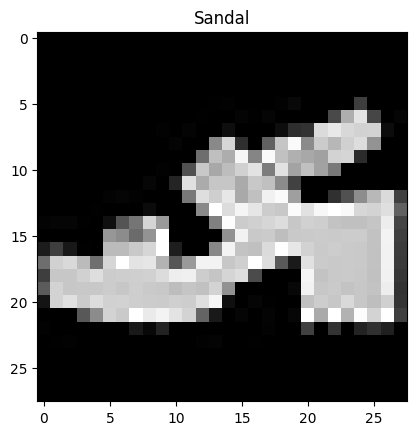

In [ ]:
plt.imshow(test_samples[0].squeeze(),cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
pred_probs=make_predictions(model=model1,
                            data=test_samples,
                            device=device)
pred_probs[:2]

tensor([[3.1200e-08, 2.2255e-08, 5.4760e-09, 5.0863e-08, 2.4303e-09, 9.9997e-01,
         7.3111e-08, 2.3191e-06, 5.3925e-06, 2.4402e-05],
        [7.0610e-02, 5.6094e-01, 1.2262e-03, 1.9241e-01, 3.8399e-02, 1.8128e-04,
         1.3537e-01, 2.5780e-04, 1.2605e-04, 4.6967e-04]])

In [ ]:
#convert pred to label
pred_classes=pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [ ]:
from tqdm.auto import tqdm
y_preds=[]
model1.eval()
with torch.inference_mode():
  for x, y in tqdm(test_dataloader, desc="Making prediction...."):
    x,y=x.to(device), y.to(device)
    y_logit= model1(x)
    y_pred= torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred)
#print(y_preds)
y_pred_tensor= torch.cat(y_preds)
y_pred_tensor[:10]

Making prediction....:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], device='cuda:0')

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#confusion metrix
import mlxtend
import torchmetrics

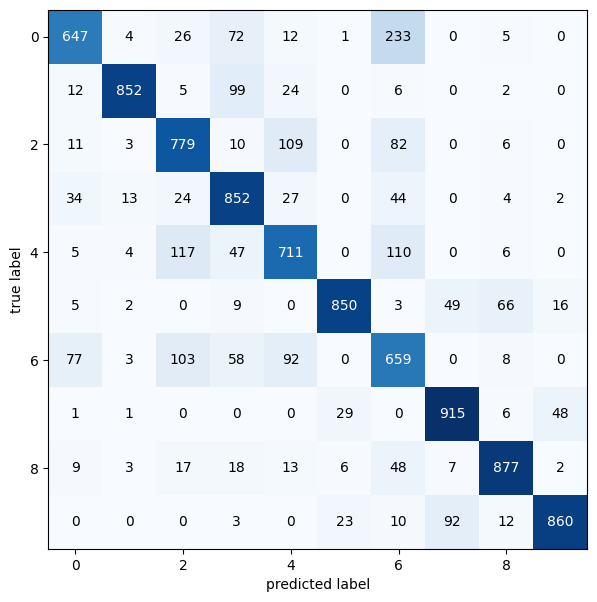

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat= ConfusionMatrix(num_classes=len(class_names), task="multiclass").to(device)
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets.to(device))
# plot metrix 
#matplot lib needs numpy
fig, ax=plot_confusion_matrix(conf_mat=confmat_tensor.cpu().numpy(),
                              figsize=(10,7))

In [ ]:
from pathlib import Path

Model_Path=Path("models")
Model_Path.mkdir(parents=True,
                 exist_ok=True)

#create model save
Model_Name="computer_vision_CNN_Model1.pth"
Model_Save_Path= Model_Path / Model_Name

Model_Save_Path

PosixPath('models/computer_vision_CNN_Model1.pth')

In [ ]:
#save model state dict

print(f"Save model to:{Model_Save_Path}")
torch.save(obj=model1.state_dict(),
           f=Model_Save_Path)

Save model to:models/computer_vision_CNN_Model1.pth


In [ ]:
# craete new instance of model1
torch.manual_seed(42)
loaded_model1=FashionModel_1(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names))

loaded_model1.load_state_dict(torch.load(f=Model_Save_Path))

<All keys matched successfully>

In [ ]:
loaded_model1.to(device)

FashionModel_1(
  (Conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
#evaluate
torch.manual_seed(42)
loaded_model1_results=modeleval(
    model=loaded_model1,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy
    
)

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
loaded_model1_results

{'model_name': 'FashionModel_1',
 'model_loss': 0.31806856393814087,
 'model_acc': tensor(0.8860, device='cuda:0')}